In [1]:
from custum_frozen_lake_env import CustumFrozenLakeEnv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### Helper Function

In [2]:
def display_q_value(value, title="State Action Value (Q) Function",map_type="8x8", fig_size = 12, char_size = 8): # Visualize q value
    n_state, n_action = value.shape

    if map_type == "8x8":
        nRow = 8
    elif map_type == "4x4":
        nRow = 4
    
    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])

    # Color
    high_color = np.array([1,1,0,0.8])
    low_color = np.array([0,0,1,0.8])
    
    fig = plt.figure(num=0,figsize=(fig_size,fig_size))
    plt.title(title,fontsize=char_size*2)  
    for i in range(nRow):
        for j in range(nRow):
            s = i*nRow+j
            min_q = np.min(value[s])
            max_q = np.max(value[s])
            for a in range(n_action):
                val = value[s,a]
                ratio = (val - min_q)/(max_q - min_q + 1e-10) # reward color (red : high, blue : low)
                if ratio > 1: clr = high_color
                elif ratio < 0: clr = low_color
                else: clr = high_color*ratio + low_color*(1-ratio)

                if a == 0: # Left arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+lft_tri, color=clr, ec='k'))
                    plt.text(j-0.4, i+0.1, "{:2.3f}".format(val), fontsize=char_size)
                if a == 1: # Down arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+dw_tri, color=clr, ec='k'))
                    plt.text(j-0.1, i+0.4, "{:2.3f}".format(val), fontsize=char_size)
                if a == 2: # Right arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+rgh_tri, color=clr, ec='k'))
                    plt.text(j+0.2, i+0.1, "{:2.3f}".format(val), fontsize=char_size)
                if a == 3: # Up arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+up_tri, color=clr, ec='k'))
                    plt.text(j-0.1, i-0.2, "{:2.3f}".format(val), fontsize=char_size)
    plt.xlim([-0.5,nRow-0.5])
    plt.xticks(range(nRow))
    plt.ylim([-0.5,nRow-0.5])
    plt.yticks(range(nRow))
    plt.gca().invert_yaxis()
    plt.show()
    
def display_episode(fig_size = 8, char_size = 8, map_type="8x8"):
    
    if map_type == "8x8":
        nRow = 8
    elif map_type == "4x4":
        nRow = 4
    
    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])

    # Color
    arr_len = 0.2

    fig = plt.figure(num=0,figsize=(fig_size,fig_size))
    plt.title("Episode",fontsize=char_size*2)  
    for state, action, reward, next_state, next_action, done in episode:
        j = state%nRow
        i = (state - j)/nRow

        if action == 0: # Left arrow
            plt.arrow(j,i,-arr_len,0,color="r",alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)
        if action == 1: # Down arrow
            plt.arrow(j,i,0,arr_len,color="r",alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)
        if action == 2: # Right arrow
            plt.arrow(j,i,arr_len,0,color="r",alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)
        if action == 3: # Up arrow
            plt.arrow(j,i,0,-arr_len,color="r",alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)

    plt.xlim([-0.5,nRow-0.5])
    plt.xticks(range(nRow))
    plt.ylim([-0.5,nRow-0.5])
    plt.yticks(range(nRow))
    plt.gca().invert_yaxis()
    plt.show()

# Environment

In [3]:
env = CustumFrozenLakeEnv(map_name="8x8")

env.seed(seed=0)
np.random.seed(seed=0)

obs_space = env.observation_space
n_state = obs_space.n
print('Observation space')
print("Total {} states".format(n_state))

act_space = env.action_space
n_action = act_space.n
print('Action space')
print("Total {} actions".format(n_action))

env.reset()
env.render()

Observation space
Total 64 states
Action space
Total 4 actions

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


# SARSA

For model-free policy iteration,
we need to estimate the following update using samples!!

$Q_{k+1}(s,a) = \sum_{s'} \left[r(s,a,s') + \gamma \sum_{a'} Q_{k}(s',a') \pi(a'|s') \right] P(s'|s,a)$

Update Q value using temporal difference (TD) target and error!!

$Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (R_{t+1} + \gamma Q_{old}(S_{t+1},A_{t+1}) - Q_{old}(S_{t}, A_{t}))$

We can update our estimator online, just $(S_{t},A_{t},R_{t+1},S_{t+1},A_{t+1})$ is needed.

TD target is $R_{t+1} + \gamma Q(S_{t+1},A_{t+1})$

TD error is $R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_{t},A_{t})$

Algorithm
--
---
For every time step

Policy Evaluation

- $(S_{t},A_{t},R_{t+1},S_{t+1},A_{t+1})$

- $TDtarget = R_{t+1} + \gamma Q(S_{t+1},A_{t+1})$

- $TDerror = R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_{t},A_{t})$

- $Q[S_{t}, A_{t}] = Q[S_{t}, A_{t}] + \alpha TDerror$

Policy Improvement

- $\pi(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

In [4]:
class SARSAAgent():
    def __init__(self, n_state, n_action, epsilon=1.0, alpha=0.5, gamma=0.999):
        
        self.n_state = n_state
        self.n_action = n_action
        
        # initial Q value
        self.q = np.zeros([n_state,n_action])
        
        self.epsilon = epsilon # initial epsilon
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor

    def update_value(self, state, action, reward, next_state, next_action, done):
        q_old = self.q[state][action]
        if done: # If the next state is terminal, don't add our estimation
            td_target = reward # This is the exact Q value at the current state
        else:
            td_target = reward + self.gamma * self.q[next_state][next_action] # r + gamma * Q(S',A')
        td_error = td_target - q_old # TD error
        self.q[state, action] = q_old + self.alpha * td_error # Update Q(S,A)

    def update_policy(self, update_rate):
        self.epsilon = np.min([update_rate,1])
        
    def get_action(self, state):
        if np.random.uniform() < self.epsilon:
            action = np.random.randint(0, high=self.n_action)
        else:
            action = np.argmax(self.q[state])
        return action
    
if __name__=='__main__': 
    sarsaagent = SARSAAgent(n_state,n_action)

# Run SARSA Agent

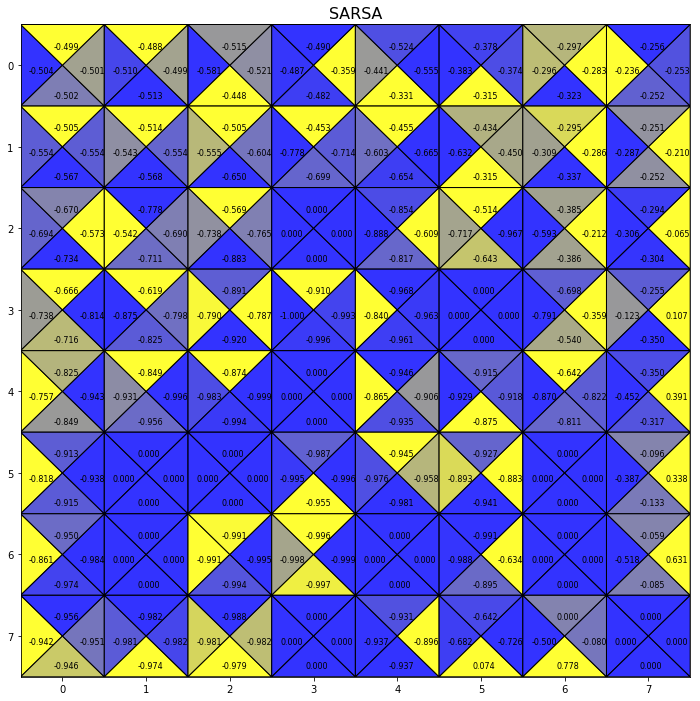

In [5]:
n_episode = 10000
for episode in range(n_episode):
    state = env.reset()
    action = sarsaagent.get_action(state)
    done = False
    while not done:    
        
        next_state, reward, done, info = env.step(action)
        next_action = sarsaagent.get_action(next_state)

        sarsaagent.update_value(state, action, reward, next_state, next_action, done) # Online Update!!
        
        state = next_state
        action = next_action
    
    sarsaagent.update_policy(1000/(episode+1)) # Decaying epsilon per episodes
display_q_value(sarsaagent.q,title="SARSA")

# SRASA($\lambda$)

For model-free policy iteration,
we need to estimate the following update using samples!!

$Q_{k+1}(s,a) = \sum_{s'} \left[r(s,a,s') + \gamma \sum_{a'} Q_{k}(s',a') \pi(a'|s') \right] P(s'|s,a)$

Update Q value using TD($\lambda$) target and error!!

$Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (G_{t}^{\lambda} - Q_{old}(S_{t}, A_{t}))$

We can update our estimator online, but we need more memory to store eligibility traces 

$E_{t}(s) = \gamma \lambda E_{t-1} (s) + \mathbf{1}\left(S_{t} = s\right)$

Algorithm
--
---
For every time step

Policy Evaluation

- $(S_{t},A_{t},R_{t+1},S_{t+1},A_{t+1})$

- $\delta = R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_{t},A_{t})$

- $E[S_{t}, A_{t}] = E[S_{t}, A_{t}] + 1$

- Update all state and action pairs at once

- $Q \leftarrow Q + \alpha \delta E$

- $E \leftarrow \gamma \lambda E$

Policy Improvement

- $\pi(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

In [6]:
class SARSAlambdaAgent():
    def __init__(self, n_state, n_action, epsilon=1.0, alpha=0.5, gamma=0.999, lam=0.2):
        
        self.n_state = n_state
        self.n_action = n_action
        
        # initial Q value
        self.q = np.zeros([n_state,n_action])
        # initial Eligibility Trace
        self.eligibility_trace = np.zeros([n_state,n_action])
        
        self.epsilon = epsilon # initial epsilon
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor
        self.lam = lam # lambda
        
    def update_value(self, state, action, reward, next_state, next_action, done):
        
        q_old = self.q[state][action]
        # TD target
        if done:
            td_target = reward
        else:
            td_target = reward + self.gamma * self.q[next_state][next_action]
        td_error = td_target - q_old # TD error
        
        self.eligibility_trace[state][action] += 1 # Update eligibility trace
        
        self.q = self.q + self.alpha * td_error * self.eligibility_trace  # Update All
        
        self.eligibility_trace = self.gamma * self.lam * self.eligibility_trace # Decay eligibility

    def update_policy(self, update_rate):
        self.epsilon = np.min([update_rate,1])
        
    def get_action(self, state):
        if np.random.uniform() < self.epsilon:
            action = np.random.randint(0, high=self.n_action)
        else:
            action = np.argmax(self.q[state])
        return action
        
if __name__=='__main__': 
    sarsalamagent = SARSAlambdaAgent(n_state,n_action)

# Run SASRA($\lambda$) Agent

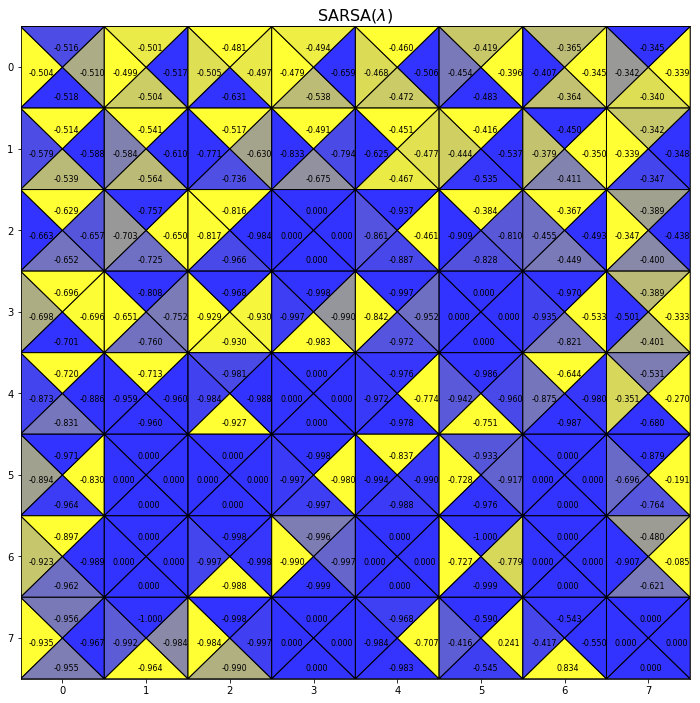

In [7]:
n_episode = 10000
for episode in range(n_episode):
    state = env.reset()
    action = sarsalamagent.get_action(state)
    done = False
    while not done:    
        
        next_state, reward, done, info = env.step(action)
        next_action = sarsalamagent.get_action(next_state)

        sarsalamagent.update_value(state, action, reward, next_state, next_action, done)
        
        state = next_state
        action = next_action
    
    sarsalamagent.update_policy(1000/(episode+1))
display_q_value(sarsalamagent.q,title="SARSA($\lambda$)")

# SARSA and SARSA($\lambda$)

Let's compare update mechanism of SARSA and SARSA($\lambda$) for single episode

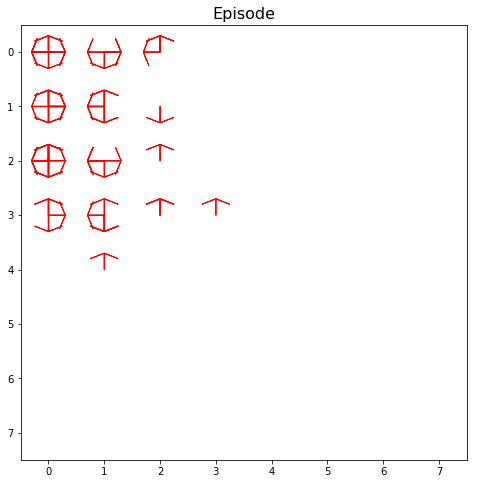

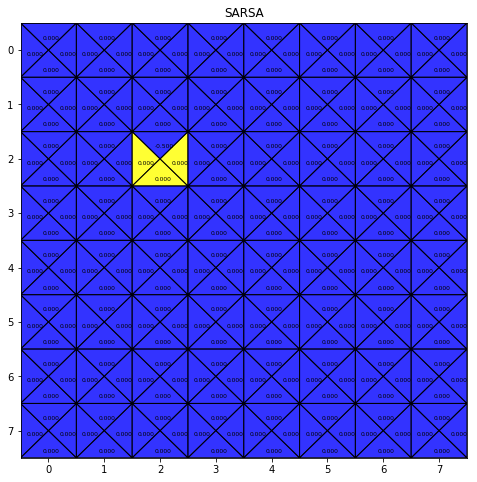

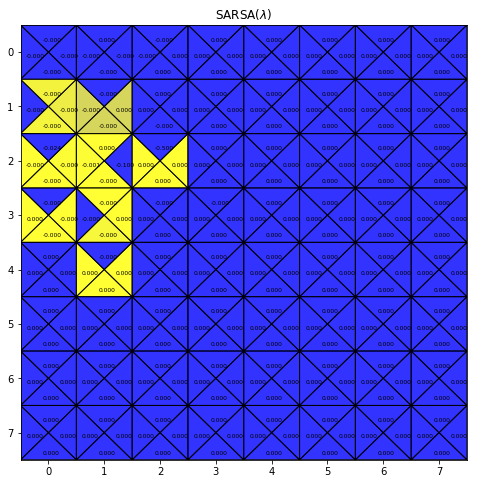

In [8]:
# Sample One Trajectory
state = env.reset()
action = env.action_space.sample()
done = False
episode = []
while not done:    

    next_state, reward, done, info = env.step(action)
    next_action = env.action_space.sample()

    episode.append([state, action, reward, next_state, next_action, done])

    state = next_state
    action = next_action

# Make Agents
sarsaagent = SARSAAgent(n_state,n_action)
sarsalamagent = SARSAlambdaAgent(n_state,n_action)

# Update two agents using sampled trajectory
for state, action, reward, next_state, next_action, done in episode:
    sarsaagent.update_value(state, action, reward, next_state, next_action, done)
    sarsalamagent.update_value(state, action, reward, next_state, next_action, done)
    
display_episode(fig_size = 8, char_size = 8)
display_q_value(sarsaagent.q,title="SARSA",fig_size=8,char_size=6)
display_q_value(sarsalamagent.q,title="SARSA($\lambda$)",fig_size=8,char_size=6)